## Manifold Analysis

#### 1. Load Distance Matrix: This is the starting point where we load the distance matrix.

#### 2. Estimate Optimal Sigma: We estimate the optimal sigma value for the Gaussian kernel, which is crucial for the diffusion map embedding.

#### 3. Construct Laplacian Matrix: From the distance matrix, construct the Laplacian matrix, which represents the graph of data points. The construction can vary (e.g., using adjacency matrices, degree matrices, etc.), but it essentially captures the local geometry of the data.

#### 4. Perform Spectral Decomposition: Decompose the Laplacian matrix to obtain its eigenvalues and eigenvectors. The eigenvectors serve as the new coordinates in the embedded space, while the eigenvalues can indicate the significance of each dimension.

#### 5. Apply Manifold Trimming: Based on a specified radius, trim the dataset to refine its representation. This step involves removing outliers or points that are not within a defined core region of the data manifold.

#### 6. Repeat Steps 2-5 for Refinement: Depending on the results, we may need to iterate over the estimation of sigma, reconstruction of the Laplacian, spectral decomposition, and trimming to refine the manifold representation.

#### 7. Save Final Outputs: After reaching a satisfactory representation, we save the final set of points, embedding coordinates, eigenvalues, and any other relevant data for further analysis or visualization.

In [1]:
from scipy.sparse.linalg import eigsh, ArpackNoConvergence
from scipy.optimize import curve_fit, OptimizeWarning
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_s_curve
from collections import namedtuple
import matplotlib.pyplot as plt
from functools import partial
from scipy.linalg import eigh
import multiprocessing
import seaborn as sns
from tqdm import tqdm
import numpy as np
import traceback
import mrcfile
import pickle
import tqdm
import sys
import os
from params import p
project_name = "sample"

In [2]:
# Set the project name to before loading the parameters
p.proj_name = project_name
# When we call p.load(), it should attempt to load "params_sample.toml"
p.load()
# Print the parameters to verify they are loaded correctly
print(p)

In [3]:
class NullEmitter:
    """
    A class that provides a no-operation (no-op) implementation of an emitter.

    This class is designed to be used in contexts where an emitter is required by the interface,
    but no actual emitting action is desired. It effectively serves as a placeholder or a stub
    that satisfies the requirement of having an emitter without performing any operation.
    """
    
    def emit(self, percent):
        """
        A no-operation implementation of the emit method.

        This method is intended to fulfill the interface requirement for an emitting action
        without performing any actual work. It can be used to ignore progress updates or
        other emitting actions in a safe and controlled manner.

        Parameters:
        - percent (any): This parameter is accepted to match the expected interface of an
          emitter method, but it is not used within the method. Any value passed to this
          parameter will be ignored.

        Returns:
        None
        """
        pass

In [4]:
def debug_print(msg: str=""):
    """
    Prints a debug message along with the caller's stack trace.

    Parameters:
    - msg (str): The debug message to print. If empty, only the stack trace is printed.

    Returns:
    None
    """
    if msg:
        print(msg)
    stack = traceback.format_stack()
    print(stack[-2].split('\n')[0])

In [5]:
def fin1(filename):
    """
    Reads and returns the data from a pickle file.

    This function attempts to open a file in binary read mode and deserialize its contents using
    pickle. If an exception occurs during this process, it logs the exception message using
    `debug_print` and returns None.

    Parameters:
    - filename (str): The path to the file to be read.

    Returns:
    - The deserialized data from the file if successful, None otherwise.
    """
    with open(filename, 'rb') as f:
        try:
            data = pickle.load(f)
            return data
        except Exception as e:
            debug_print(str(e))
            return None

In [6]:
def fout1(filename, **kwargs):
    """
    Writes the given keyword arguments to a file using pickle serialization.

    This function opens a file in binary write mode and serializes the keyword arguments passed to
    it using pickle, with the highest available protocol. It ensures that the data is written
    efficiently and securely.

    Parameters:
    - filename (str): The path to the file where the data will be written.
    - **kwargs: Arbitrary keyword arguments that will be serialized and written to the file.

    Returns:
    None
    """
    with open(filename, 'wb') as f:
        pickle.dump(kwargs, f, protocol=pickle.HIGHEST_PROTOCOL)
    # Note: The file is automatically closed when exiting the 'with' block, so f.close() is not necessary.

In [7]:
def fergusonE(D, logEps, a0=None):
    """
    Fits a curve using a hyperbolic tangent function to the data provided and returns the optimized parameters.

    This function attempts to fit a curve defined by a hyperbolic tangent function to the given data points.
    It uses the scipy.optimize.curve_fit method for curve fitting. The function also calculates the threshold
    for weighting the data points based on the provided logarithmic epsilon values and distances.

    Parameters:
    - D (np.ndarray): An array of distances between data points.
    - logEps (np.ndarray): An array of logarithmic epsilon values to be used for curve fitting.
    - a0 (np.ndarray, optional): Initial guess for the parameters of the hyperbolic tangent function.
      If None, a default value of ones(4) is used.

    Returns:
    - tuple: A tuple containing the following elements:
        - popt (np.ndarray): Optimal values for the parameters so that the sum of the squared residuals
          of fun(xdata, *popt) - ydata is minimized.
        - logSumWij (np.ndarray): Logarithm of the sum of weighted distances for each logEps value.
        - resnorm (float): The sum of the square roots of the absolute values of the diagonal of the
          covariance matrix of the parameters.
        - R_squared (float): Coefficient of determination, indicating the proportion of the variance in
          the dependent variable that is predictable from the independent variable(s).

    Notes:
    - The function internally defines a `fun` function representing a hyperbolic tangent model and a
      `find_thres` function to calculate a threshold for weighting the data points.
    - The curve fitting process iterates until the residual norm (resnorm) is less than 100, adjusting
      the initial guess for the parameters (a0) in each iteration if necessary.
    - This function uses scipy's curve_fit method, which may not converge to a solution; in such cases,
      it prints the residual norm, the parameters attempted, and the error identifier (ier).
    """
    if a0 is None:
        a0 = np.ones(4)
    def fun(x, a, b, c, d):
        return d + c * np.tanh(a * x + b)
    def find_thres(logEps, D2):
        d = 0.5 * D2 / np.exp(np.max(logEps))
        ss = np.sum(np.exp(-d))
        return max(-np.log(0.01 * ss / len(D2)), 10)  # Taking 1% of the average (10)
    # Range of values to try:
    logSumWij = np.empty_like(logEps)
    D2 = D * D
    thr = find_thres(logEps, D2)
    for k, le in enumerate(logEps):
        d = 0.5 * D2 / np.exp(le)
        Wij = np.exp(-d[d < thr])  # See Coifman 2008
        logSumWij[k] = np.log(np.sum(Wij))
    # Curve fitting of a tanh():
    resnorm = np.inf
    while (resnorm > 100):
        popt, pcov, infodict, mesg, ier = curve_fit(fun, logEps, logSumWij, p0=a0, full_output=True)
        resnorm = np.sum(np.sqrt(np.fabs(np.diag(pcov))))
        if ier < 1 or ier > 4:
            print(resnorm, popt, ier)
        a0 *= 0.5
        residuals = logSumWij - fun(logEps, *popt)
        ss_res = np.sum(residuals**2)  # Residual sum of squares
        ss_tot = np.sum((logSumWij - np.mean(logSumWij))**2)  # Total sum of squares
        R_squared = 1 - (ss_res / ss_tot)  # R**2 value
    return (popt, logSumWij, resnorm, R_squared)

### Example illustration for the fergusonE function

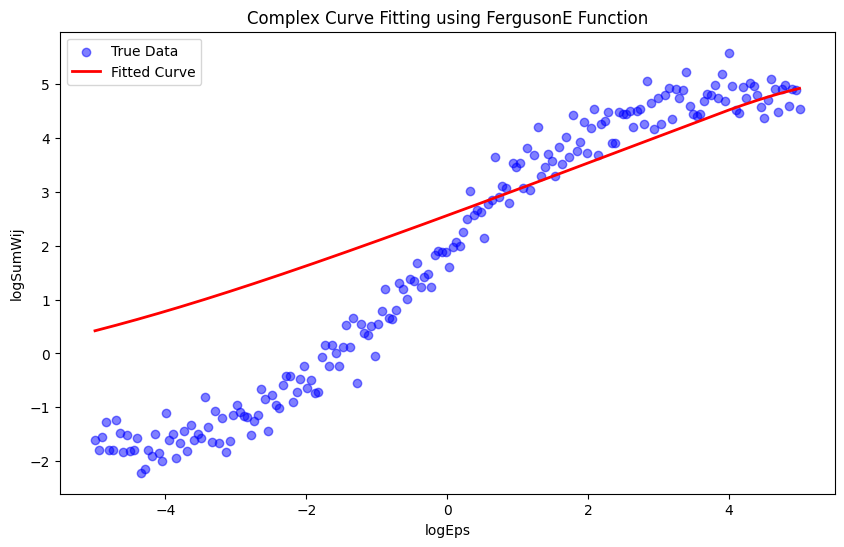

Optimized parameters: [ 0.09310216 -0.12838814  5.29985446  3.23847264]
Residual norm: 0.07144811567867053
R-squared: 0.9999736698179453


In [8]:
# Generate data
np.random.seed(42)
logEps = np.linspace(-5, 5, 200)  # Extended range for logEps
D = np.linspace(0, 20, 200)  # Extended range for distances

# Generate true logSumWij values with a complex relationship
true_params1 = [0.5, 0.1, 2.0, 0.5]
true_params2 = [-0.3, -0.2, -1.5, 1.0]
true_logSumWij = true_params1[3] + true_params1[2] * np.tanh(true_params1[0] * logEps + true_params1[1]) \
                + true_params2[3] + true_params2[2] * np.tanh(true_params2[0] * logEps + true_params2[1]) \
                + np.random.normal(0, 0.3, size=logEps.shape)

# Fit the curve with an initial guess far from the true parameters
a0 = np.array([2.0, 2.0, -2.0, -2.0])
popt, logSumWij, resnorm, R_squared = fergusonE(D, logEps, a0)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(logEps, true_logSumWij, label='True Data', color='blue', alpha=0.5)
plt.plot(logEps, logSumWij, label='Fitted Curve', color='red', linewidth=2)
plt.title('Complex Curve Fitting using FergusonE Function')
plt.xlabel('logEps')
plt.ylabel('logSumWij')
plt.legend()
plt.axis('on')
plt.grid(False)
plt.show()
# Output the optimized parameters and goodness-of-fit measures
print(f"Optimized parameters: {popt}")
print(f"Residual norm: {resnorm}")
print(f"R-squared: {R_squared}")

In [9]:
def slaplacian(*arg):
    """
    Given a set of nS data points, and the distances to nN nearest neighbors
    for each data point, slaplacian computes a sparse, nY by nY symmetric
    graph Laplacian matrix l.

    The input data are supplied in the column vectors yVal and yInd of length
    nY * nN such that

    yVal( ( i - 1 ) * nN + ( 1 : nN ) ) contains the distances to the
    nN nearest neighbors of data point i sorted in ascending order, and

    yInd( ( i - 1 ) * nN + ( 1 : nN ) ) contains the indices of the nearest
    neighbors.

    yVal and yInd can be computed by calling nndist

    slaplacian admits a number of options passed as name-value pairs

    alpha : normalization, according to Coifman & Lafon

    nAutotune : number of nearest neighbors for autotuning. Set to zero if no
    autotuning is to be performed

    sigma: width of the Gaussian kernel
    """
    yVal = arg[0]
    yCol = arg[1]
    yRow = arg[2]
    nS = arg[3]  # dataset size
    options = arg[4]  # options.sigma: Gaussian width
    nNZ = len(yVal)  # Number of nonzero elements

    # If required, compute autotuning distances:
    if options.autotune > 0:
        print('Autotuning is not implemented in this version of slaplacian' + '\n')
    else:
        sigmaTune = options.sigma

    yVal = yVal / sigmaTune**2
    # Compute the unnormalized weight matrix:
    yVal = np.exp(-yVal)  # apply exponential weights (yVal is distance**2)
    l = csc_matrix((yVal, (yRow, yCol)), shape=(nS, nS))
    d = np.array(l.sum(axis=0)).T

    if options.alpha != 1:  # apply non-isotropic normalization
        d = d**options.alpha

    yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))
    l = csc_matrix((yVal, (yRow, yCol)), shape=(nS, nS))

    # Normalize by the degree matrix to form normalized graph Laplacian:
    d = np.array(l.sum(axis=0))
    d = np.sqrt(d).T
    yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))
    l = csc_matrix((yVal, (yRow, yCol)), shape=(nS, nS))
    l = np.abs(l + l.T) / 2.0  # iron out numerical wrinkles
    temp = l - l.T

    return (l, sigmaTune)

### Example illustration for the slaplacian function

To demonstrate the slaplacian function, we need to simulate a scenario where we have a set of data points and their distances to their nearest neighbors. We will simulate a small dataset and compute the sparse graph Laplacian matrix using the slaplacian function.

1. Simulating data points: We will create a simple set of data points.

2. Computing nearest neighbors and distances: Although the real computation of nearest neighbors and distances (yVal and yCol) would require a method like nndist, for simplicity, we will simulate these values directly.

3. Using slaplacian: We will pass these simulated values to slaplacian along with a set of options.

4. Visualizing the Laplacian matrix: To illustrate the output, we will visualize the sparse graph Laplacian matrix as a heatmap.

#### Note: The warnings indicate two common numerical issues encountered during the computation of the graph Laplacian matrix:

1. Divide by Zero: This warning arises when there are zero values in the degree matrix d, leading to division by zero during normalization. This situation can occur if some nodes in the graph are isolated (i.e., have no edges connecting them to other nodes), resulting in a zero degree.

2. Invalid Values in Multiplication: This warning typically follows the divide by zero warning and indicates that the operation has resulted in NaN (Not a Number) or inf (infinity) values in the array. This is a consequence of attempting to normalize using invalid or zero values.

[0.87737307 0.74076862 0.69701574 0.70248408 0.35949115 0.29359184
 0.80936116 0.81011339 0.86707232 0.91324055 0.5113424  0.50151629
 0.79829518 0.64996393 0.70196688 0.79579267 0.89000534 0.33799516
 0.37558295 0.09398194 0.57828014 0.03594227 0.46559802 0.54264463
 0.28654125 0.59083326 0.03050025 0.03734819 0.82260056 0.36019064]
[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
[0 0 0 1 2 2 2 3 3 3 4 4 4 4 4 4 5 6 6 6 6 7 7 7 8 9 9 9 9 9]
[[ 0.  0.  0. nan nan  0. nan nan nan nan]
 [ 0.  0.  0. nan nan nan nan nan  0. nan]
 [ 0.  0.  0. nan nan  0. nan nan  0. nan]
 [nan nan nan  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan  0.  0.  0.  0.  0.  0.  0.]
 [ 0. nan  0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan  0.  0.  0.  0.  0.  0.  0.]
 [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan  0.  0.  0.  0.  0.  0.  0.]]


/tmp/ipykernel_29424/3742867316.py:49: RuntimeWarning: divide by zero encountered in divide
  yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))
/tmp/ipykernel_29424/3742867316.py:55: RuntimeWarning: invalid value encountered in multiply
  yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))


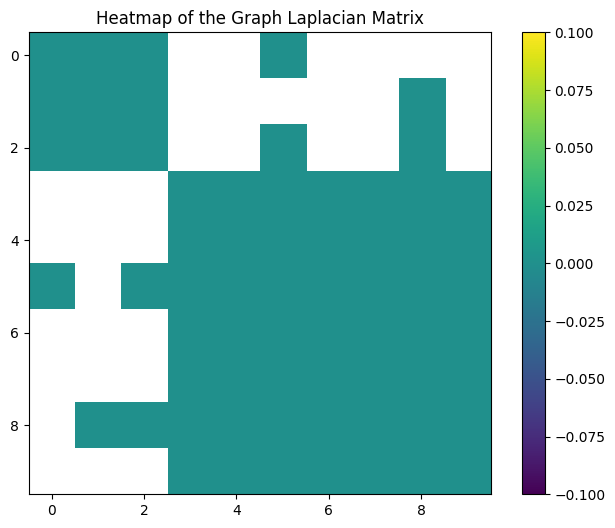

In [10]:
# Simulate input data for the slaplacian function
nS = 10  # Number of data points
nN = 3   # Number of nearest neighbors for each data point
yVal = np.random.rand(nS * nN)  # Random distances to nearest neighbors
print(yVal)
yCol = np.tile(np.arange(nN), nS)  # Column indices for nearest neighbors
print(yCol)
yRow = np.sort(np.random.choice(nS, nS * nN, replace=True))  # Row indices, simulated
print(yRow)

# Define options for the slaplacian function
options = namedtuple('Options', 'sigma alpha autotune')(sigma=1.0, alpha=0.5, autotune=0)

# Compute the Laplacian matrix using the slaplacian function
l, sigmaTune = slaplacian(yVal, yCol, yRow, nS, options)

# Convert the sparse Laplacian matrix to a dense format for visualization
l_dense = l.toarray()
print(l_dense)

# Visualize the Laplacian matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(l_dense, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.axis('on')
plt.grid(False)
plt.title('Heatmap of the Graph Laplacian Matrix')
plt.show()

In [11]:
def sembedding(yVal, yCol, yRow, nS, options1):
    """
    Laplacian eigenfunction embedding using sparse arrays.

    This function computes the eigenvalues and eigenvectors of the Laplacian matrix of a graph,
    which represents the dataset. The Laplacian matrix is constructed based on the input sparse
    matrix components (values, column indices, row pointers) and options specifying the embedding
    parameters.

    Parameters:
    - yVal (np.ndarray): The values of the non-zero elements in the sparse matrix representation.
    - yCol (np.ndarray): The column indices of the non-zero elements in the sparse matrix.
    - yRow (np.ndarray): The row indices of the non-zero elements in the sparse matrix.
    - nS (int): The number of samples or nodes in the graph.
    - options1 (namedtuple): A namedtuple containing the options for the embedding. Expected fields
      are sigma (float), alpha (float), visual (bool), nEigs (int), and autotune (int).

    Returns:
    - tuple: A tuple containing the following elements:
        - vals (np.ndarray): The computed eigenvalues of the Laplacian matrix.
        - vecs (np.ndarray): The computed eigenvectors of the Laplacian matrix, corresponding to the eigenvalues.

    Notes:
    - The function attempts to compute the specified number of eigenvalues and eigenvectors using
      the ARPACK solver via scipy.sparse.linalg.eigsh. If the solver does not converge within the
      specified maximum number of iterations, it catches the ArpackNoConvergence exception and
      returns the eigenvalues and eigenvectors that were computed up to that point.
    """
    # Create a new options namedtuple with values from options1
    options = namedtuple('options', 'sigma alpha visual nEigs autotune')
    options.sigma = options1.sigma
    options.alpha = options1.alpha
    options.nEigs = options1.nEigs
    options.autotune = 0  # Autotuning is disabled in this implementation

    # Compute the sparse Laplacian matrix
    l, sigmaTune = slaplacian(yVal, yCol, yRow, nS, options)

    # Attempt to compute the eigenvalues and eigenvectors of the Laplacian matrix
    try:
        vals, vecs = eigsh(l, k=options.nEigs + 1, maxiter=300, v0=np.ones(nS), return_eigenvectors=True)
    except ArpackNoConvergence as e:
        # Handle the case where ARPACK does not converge within the maximum number of iterations
        vals = e.eigenvalues
        vecs = e.eigenvectors
        print("eigsh not converging in 300 iterations...")

    # Sort the eigenvalues and eigenvectors in descending order
    ix = np.argsort(vals)[::-1]
    vals = vals[ix]
    vecs = vecs[:, ix]

    return (vals, vecs)

### Example illustration for the sembedding function

Let us go through the process to compute the eigenvalues and eigenvectors for graph embedding and visualize the 2D embedding. We will simulate the input data compatible with these functions and follow through with the visualization.

1. Simulate Input Data: Generate appropriate input data for the slaplacian function.

2. Compute the Laplacian Matrix: Use the slaplacian function to compute the Laplacian matrix of the graph.

3. Compute Embedding: Apply the sembedding function to obtain the eigenvalues and eigenvectors, which will be used for embedding.

4. Visualization: Visualize the first two non-trivial eigenvectors as a 2D embedding of the graph.

/tmp/ipykernel_29424/3742867316.py:49: RuntimeWarning: divide by zero encountered in divide
  yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))
/tmp/ipykernel_29424/3742867316.py:55: RuntimeWarning: invalid value encountered in multiply
  yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))


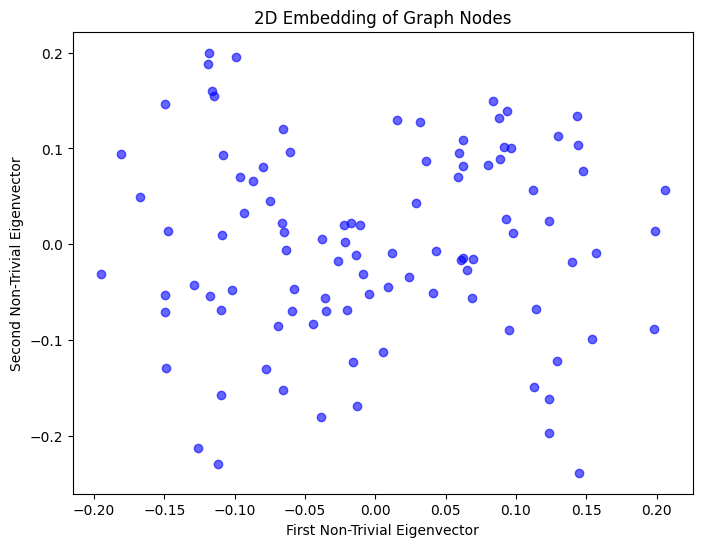

In [12]:
# Simulate input data for slaplacian and sembedding
nS = 100  # Number of samples/nodes
yVal = np.random.rand(nS * 10)  # Simulated distances
yCol = np.tile(np.arange(10), nS)  # Simulated column indices
yRow = np.repeat(np.arange(nS), 10)  # Simulated row indices

# Options for slaplacian and sembedding
options1 = namedtuple('Options', 'sigma alpha visual nEigs autotune')(
    sigma=1.0, 
    alpha=1.0, 
    visual=False, 
    nEigs=2, 
    autotune=0
)

# Compute the embedding
vals, vecs = sembedding(yVal, yCol, yRow, nS, options1)

# Visualization of the 2D embedding
plt.figure(figsize=(8, 6))
plt.scatter(vecs[:, 1], vecs[:, 2], c='blue', alpha=0.6)
plt.title('2D Embedding of Graph Nodes')
plt.xlabel('First Non-Trivial Eigenvector')
plt.ylabel('Second Non-Trivial Eigenvector')
plt.axis('on')
plt.grid(False)
plt.show()

In [13]:
def get_yColVal(params):
    """
    Processes and updates arrays for values and column indices in a sparse matrix representation.

    This function takes a set of parameters related to the sparse matrix construction, including
    arrays of values and indices, and updates these arrays based on the provided batch of data.
    It is typically used in the context of constructing or updating a sparse representation of a
    graph or matrix, especially when dealing with large datasets that require batching.

    Parameters:
    - params (tuple): A tuple containing the following elements:
        - yVal (np.ndarray): The values of the non-zero elements in the sparse matrix.
        - yVal1 (np.ndarray): The original values from which yVal will be updated.
        - yCol (np.ndarray): The column indices of the non-zero elements in the sparse matrix.
        - yInd1 (np.ndarray): The original indices from which yCol will be updated.
        - nB (int): The batch size, indicating the number of data points processed in this batch.
        - nN (int): The number of nearest neighbors considered for each data point.
        - nNIn (int): The initial number of nearest neighbors before filtering.
        - jStart (int): The start index of the current batch.
        - jEnd (int): The end index of the current batch.
        - indStart (int): The start index for updating yVal and yCol.
        - indEnd (int): The end index for updating yVal and yCol.
        - iBatch (int): The current batch number.

    Returns:
    - tuple: A tuple containing the updated yCol and yVal arrays.

    Notes:
    - The function reshapes and filters the input arrays yVal1 and yInd1 based on the batch
      information and the number of nearest neighbors. It then updates the yVal and yCol arrays
      with the processed data for the current batch.
    - This function is part of a larger process of constructing or updating sparse matrices and
      is designed to handle data in batches for efficiency and scalability.
    """
    yVal = params[0]
    yVal1 = params[1]
    yCol = params[2]
    yInd1 = params[3]
    nB = params[4]
    nN = params[5]
    nNIn = params[6]
    jStart = params[7]
    jEnd = params[8]
    indStart = params[9]
    indEnd = params[10]
    iBatch = params[11]

    # Reshape and filter the data batch for values
    DataBatch = yVal1
    DataBatch = DataBatch.reshape(nB, nNIn).T
    DataBatch = DataBatch[:nN, :]
    DataBatch[0, :] = 0  # Reset the first row to zeros
    yVal[indStart:indEnd] = DataBatch.reshape(nN * nB, 1)

    # Reshape and filter the data batch for column indices
    DataBatch = yInd1
    DataBatch = DataBatch.reshape(nB, nNIn).T
    DataBatch = DataBatch[:nN, :]
    yCol[indStart:indEnd] = DataBatch.reshape(nN * nB, 1).astype(float)

    return (yCol, yVal)

In [14]:
def initialize(nS, nN, D):
    """
    Initializes the arrays of indices and values for constructing a sparse matrix
    representation of distances between data points.

    This function processes a distance matrix to identify the nearest neighbors for each
    data point. It then creates arrays that store the indices of these neighbors and the
    corresponding distance values. The first distance value for each data point is set to
    zero to indicate self-distance, ensuring the diagonal of the distance matrix is zero.

    Parameters:
    - nS (int): The number of samples or data points.
    - nN (int): The number of nearest neighbors to consider for each data point.
    - D (np.ndarray): A square distance matrix of shape (nS, nS) where D[i, j] represents
      the distance between the i-th and j-th data points.

    Returns:
    - tuple: A tuple containing two flattened arrays:
        - yInd1 (np.ndarray): A flattened array of indices of the nearest neighbors for each data point.
        - yVal1 (np.ndarray): A flattened array of the corresponding distance values to the nearest neighbors.

    Notes:
    - The function modifies the input distance matrix D by setting the diagonal elements to
      negative infinity to ensure that each data point's self-distance does not affect the
      nearest neighbors' calculation.
    - After identifying the nearest neighbors and their distances, the function resets the
      first distance value for each data point to zero, effectively ignoring self-distance
      in the sparse matrix representation.
    """
    yInd1 = np.zeros((nN, nS), dtype='int32')
    yVal1 = np.zeros((nN, nS), dtype='float64')
    
    for iS in range(nS):
        D[iS, iS] = -np.Inf  # Force this distance to be the minimal value
        B = np.sort(D[:, iS])
        IX = np.argsort(D[:, iS])
        yInd1[:, iS] = IX[:nN]
        yVal1[:, iS] = B[:nN]
        yVal1[0, iS] = 0  # Set this distance back to zero
    
    yInd1 = yInd1.flatten('F')
    yVal1 = yVal1.flatten('F')
    
    return (yInd1, yVal1)

In [15]:
def construct_matrix0(Row, Col, Val, nZ, nS):
    """
    Constructs a symmetric matrix from given row indices, column indices, and values,
    specifically designed for handling squared distances.

    This function first creates a sparse matrix from the given row indices, column indices,
    and values. It then converts this sparse matrix to a dense array and performs operations
    to ensure that the resulting matrix is symmetric and represents squared distances
    correctly.

    Parameters:
    - Row (np.ndarray): An array of row indices for the non-zero elements in the matrix.
    - Col (np.ndarray): An array of column indices for the non-zero elements in the matrix.
    - Val (np.ndarray): An array of values corresponding to the non-zero elements in the matrix.
    - nZ (int): The number of zero elements in the matrix. This parameter is accepted but not
      directly used in the function, indicating potential use in extended functionality or
      error checking.
    - nS (int): The size of the square matrix to be constructed, indicating both the number
      of rows and columns.

    Returns:
    - np.ndarray: A symmetric matrix constructed from the input parameters, with adjustments
      to ensure correct representation of squared distances.

    Notes:
    - The function first constructs a sparse CSR (Compressed Sparse Row) matrix from the input
      indices and values. It then converts this sparse matrix to a dense array.
    - It computes the square of the dense array and its transpose to handle squared distances.
    - The final matrix is adjusted by adding the original matrix and its transpose, then
      subtracting a matrix that contains the squares of the distances, to ensure symmetry
      and correct distance representation.
    """
    # Create a sparse CSR matrix from the given indices and values
    y = csr_matrix((Val, (Row, Col)), shape=(nS, nS)).toarray()
    
    # Compute the square of the dense array and its transpose
    y2 = y * y.T  # y2 contains the squares of the distances
    
    # Square the original matrix
    y = y**2
    
    # Adjust the matrix to ensure symmetry and correct representation of squared distances
    y = y + y.T - y2
    
    return y

In [16]:
def construct_matrix1(Row, Col, Val, nZ, nS):
    """
    Constructs a symmetric matrix from given row indices, column indices, and values.
    This version simplifies the process by directly adjusting for symmetry without explicitly
    squaring the matrix values.

    Parameters:
    - Row (np.ndarray): An array of row indices for the non-zero elements in the matrix.
    - Col (np.ndarray): An array of column indices for the non-zero elements in the matrix.
    - Val (np.ndarray): An array of values corresponding to the non-zero elements in the matrix.
    - nZ (int): The number of zero elements in the matrix. This parameter is accepted but not
      directly used in the function, indicating potential use in extended functionality or
      error checking.
    - nS (int): The size of the square matrix to be constructed, indicating both the number
      of rows and columns.

    Returns:
    - np.ndarray: A symmetric matrix constructed from the input parameters. The symmetry is
      achieved by adding the matrix to its transpose and then subtracting the element-wise
      product of the matrix and its transpose.

    Notes:
    - The function constructs a sparse CSR (Compressed Sparse Row) matrix from the input indices
      and values and then converts this sparse matrix to a dense array.
    - It ensures the symmetry of the resulting matrix by adding it to its transpose and
      subtracting the element-wise product of the matrix and its transpose, which contains
      the squares of the original distances. This operation corrects for any asymmetries
      that might arise from the input data or the sparse matrix construction process.
    """
    # Create a sparse CSR matrix from the given indices and values
    y = csr_matrix((Val, (Row, Col)), shape=(nS, nS)).toarray()
    
    # Compute the element-wise product of the matrix and its transpose
    y2 = y * y.T  # y2 contains the squares of the distances
    
    # Adjust the matrix to ensure symmetry
    y = y + y.T - y2
    
    return y

### DMembeddingIIop 

The DMembeddingIIop function performs diffusion maps embedding on a given distance matrix D with several steps involved.

#### Step 1: Initialization

    - The function initializes by defining the number of samples (nS) and the number of nearest neighbors (nN) based on the input distance matrix D and the parameter k.

    - It calls initialize to presumably prepare initial indices and values (yInd1, yVal1) for constructing a neighbor graph from D.

#### Step 2: Constructing Neighbor Graph

    - The distance matrix D is processed in batches (nBatch), each containing a subset of the data points (nB).
    
    - For each batch, it computes linear indices for diffraction patterns and updates values (yVal) and column indices (yCol) for the neighbor graph using get_yColVal.

    - After processing all batches, it symmetrizes the distance matrix to ensure it represents an undirected graph.

#### Step 3: Symmetrization of the Distance Matrix

    - Nonzero distances are identified (yRowNZ, yColNZ, yValNZ), and a sparse matrix y is constructed to represent the symmetrized neighbor graph.

    - Zero distances are processed separately, and their count (nZ) is updated.

#### Step 4: Diffusion Operator Construction

    - A Gaussian kernel width (sigma) is determined through autotuning, using the fergusonE function to optimize over logarithmically spaced logEps values.

    - The function decides on the kernel normalization parameter (alpha) based on the autotuning result and the user-provided tune parameter.

#### Step 5: Spectral Embedding

    - The spectral embedding is performed by calling sembedding, which presumably computes the eigenvalues (lamb) and eigenvectors (v) of the diffusion operator constructed from the symmetrized neighbor graph.

    - The first few eigenvectors (psi) are normalized and selected as the embedding coordinates. The number of eigenfunctions computed (nEigs) is determined based on the parameter p.num_eigs and the number of samples.

#### Step 6: Riemannian Measure

    - The Riemannian measure (mu) is calculated from the first eigenvector (v[:, 0]), which corresponds to the stationary distribution of the diffusion process.

#### Step 7: Return Statement

    - The function returns the computed eigenvalues (lamb), the selected eigenvectors (psi), the Gaussian kernel width (sigma), the Riemannian measure (mu), and additional information related to the autotuning process (logEps, logSumWij, popt, R_squared).

The DMembeddingIIop function performs diffusion maps embedding and takes several arguments, each playing a specific role in the embedding process. 

#### D

    - Description: The distance matrix for the dataset.
    
    - Role: It represents the pairwise distances between data points in the dataset. This matrix is fundamental for constructing the affinity (or similarity) matrix that underlies the diffusion map process.

#### k

    - Description: The number of nearest neighbors to consider for each point in the dataset.
     
    - Role: It is used to define the local neighborhood around each data point when constructing the affinity matrix from the distance matrix. This parameter controls the sparsity of the affinity matrix and influences the emphasis on local versus global data structure in the resulting embedding.

#### tune

    - Description: A tuning parameter that might be used to adjust the scale of distances or the width of the Gaussian kernel during the autotuning process.
    
    - Role: It is involved in fine-tuning the Gaussian kernel width (σ) calculation, thereby affecting the sensitivity of the embedding to features at different scales.

#### prefsigma

    - Description: A preferred or preset value for the Gaussian kernel width (σ).
    
    - Role: This value is used as a fallback for the Gaussian kernel width in case the autotuning process does not yield a satisfactory result or is bypassed. It directly influences the decay rate of similarity with distance, impacting the focus of embedding on local versus global structures. The function seems to be structured to perform several key steps of the diffusion map process, including:

      - (a) Constructing an affinity matrix from the distance matrix, likely using a Gaussian kernel whose width (σ) is determined through an autotuning process.
      
      - (b) Performing eigenvalue decomposition on the affinity matrix to obtain eigenvalues (lamb) and eigenvectors (psi), which represent the embedded coordinates.
      
      - (c) The tune parameter adjusts the autotuning of σ, while prefsigma provides a direct way to specify σ.

#### Return values

    - The return values (lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared) include the eigenvalues and eigenvectors essential for understanding the geometry of the data in the embedded space, as well as diagnostic information about the autotuning process and the diffusion characteristics of the diffusion.

In [17]:
def DMembeddingIIop(D, k, tune, prefsigma):
    """
    Performs spectral embedding of data points based on their pairwise distances using
    the diffusion maps approach. This function initializes the necessary structures,
    processes the data to construct a symmetric distance matrix, and performs spectral
    decomposition to obtain embedding coordinates. Additionally, it estimates the optimal
    sigma for the Gaussian kernel using the Ferguson method.

    Parameters:
    - D (np.ndarray): A square matrix of pairwise distances between data points.
    - k (int): The number of nearest neighbors to consider.
    - tune (float): A tuning parameter for adjusting the Gaussian kernel width.
    - prefsigma (float): A predefined sigma value for the Gaussian kernel, used if the
      tuning process based on the Ferguson method does not converge.

    Returns:
    - tuple: A tuple containing the following elements:
        - lamb (np.ndarray): The computed eigenvalues of the Laplacian matrix.
        - psi (np.ndarray): The computed eigenvectors of the Laplacian matrix, representing
          the embedding coordinates.
        - sigma (float): The final sigma value used for the Gaussian kernel.
        - mu (np.ndarray): The Riemannian measure derived from the first eigenvector.
        - logEps (np.ndarray): The logarithmic epsilon values used in the Ferguson method.
        - logSumWij (np.ndarray): The logarithm of the sum of weights for each logEps value.
        - popt (np.ndarray): The optimized parameters from the Ferguson curve fitting.
        - R_squared (float): The coefficient of determination from the curve fitting.

    Notes:
    - The function begins by initializing nearest neighbors and constructing a symmetric
      distance matrix through batch processing.
    - It employs the Ferguson method to estimate the optimal sigma for the Gaussian kernel
      based on the distance matrix.
    - Spectral decomposition of the Laplacian matrix is performed to obtain the embedding
      coordinates (psi) and the eigenvalues (lamb).
    - The process includes a fallback to a predefined sigma (prefsigma) if the tuning does
      not converge within a specified threshold.
    - The Riemannian measure (mu) is calculated as the square of the first eigenvector,
      normalized so that its sum equals 1. This measure can be used to weight the embedded
      points in further analysis.
    """
    nS = D.shape[0]
    nN = k  # Total number of entries is nS*nN
    yInd1, yVal1 = initialize(nS, nN, D)

    # Diffraction patterns:
    nB = nS  # Batch size (number of diff. patterns per batch)
    nNIn = k  # Number of input nearest neighbors
    nN = k  # Number of output nearest neighbors
    yVal = np.zeros((nS * nN, 1))
    yCol = np.zeros((nS * nN, 1))
    nBatch = int(nS / nB)

    for iBatch in range(nBatch):
        # Linear indices in the non-symmetric distance matrix (indStart, indEnd)
        indStart = iBatch * nB * nN
        indEnd = (iBatch + 1) * nB * nN
        # Diffraction pattern indices (jStart, jEnd):
        jStart = iBatch * nB
        jEnd = (iBatch + 1) * nB
        params = (yVal, yVal1, yCol, yInd1, nB, nN, nNIn, jStart, jEnd, indStart, indEnd, iBatch)
        yCol, yVal = get_yColVal(params)

    # Symmetrizing the distance matrix
    yRow = np.ones((nN, 1)) * range(nS)
    yRow = yRow.reshape(nS * nN, 1)
    ifZero = yVal < 1e-6
    yRowNZ = yRow[~ifZero]
    yColNZ = yCol[~ifZero]
    yValNZ = np.sqrt(yVal[~ifZero])
    nNZ = len(yRowNZ)  # Number of nonzero elements in the non-sym matrix
    yRow = yRow[ifZero]
    yCol = yCol[ifZero]
    nZ = len(yRow)  # Number of zero elements in the non-sym matrix
    y = construct_matrix0(yRowNZ, yColNZ, yValNZ, nZ, nS)
    yRowNZ = y.nonzero()[0]
    yColNZ = y.nonzero()[1]
    yValNZ = y[y.nonzero()]
    nNZ = len(y.nonzero()[0]) # Number of nonzero elements in the sym matrix
    y = construct_matrix1(yRow, yCol, np.ones((nZ, 1)).flatten(), nZ, nS)
    y = csr_matrix((np.ones((nZ, 1)).flatten(), (yRow, yCol)), shape=(nS, nS)).toarray()
    yRow = y.nonzero()[0]
    yCol = y.nonzero()[1]
    yVal = y[y.nonzero()]
    yVal[:] = 0
    nZ = len(y.nonzero()[0])  #number of zero elements in the sym matrix
    yRow = np.hstack((yRow, yRowNZ)).astype(int)
    yCol = np.hstack((yCol, yColNZ)).astype(int)
    yVal = np.hstack((yVal, yValNZ))
    count = 0
    resnorm = np.inf
    logEps = np.arange(-150, 150.2, 0.2)
    popt, logSumWij, resnorm, R_squared = fergusonE(np.sqrt(yVal), logEps)
    nS = D.shape[0]
    nEigs = min(p.num_eigs, nS - 3)  # Number of eigenfunctions to compute
    nA = 0  # Autotuning parameter
    nN = k  # Number of nearest neighbors
    nNA = 0  # Number of nearest neighbors used for autotuning
    if count < 20:
        alpha = 1  # Kernel normalization
        sigma = tune * np.sqrt(2 * np.exp(-popt[1] / popt[0]))  # Gaussian Kernel width (=1 for autotuning)
    else:
        print('using prefsigma...')  # Fallback to predefined sigma
        sigma = prefsigma
        alpha = 1
    visual = 1
    options = namedtuple('Options', 'sigma alpha visual nEigs')
    options.sigma = sigma
    options.alpha = alpha
    options.visual = visual
    options.nEigs = nEigs
    lamb, v = sembedding(yVal, yCol, yRow, nS, options)
    true_shape = v.shape[1] - 1
    psi = np.zeros((v.shape[0], nEigs))
    psi[:, :true_shape] = v[:, 1:] / np.tile(v[:, 0].reshape((-1, 1)), (1, true_shape))
    mu = v[:, 0]
    mu = mu * mu  # The Riemannian measure
    return (lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared)

In [18]:
def get_psiPath(psi, rad, plotNum):
    """
    Identifies the indices of points in the embedded space within a specified radius from the origin.

    Parameters:
    - psi (np.ndarray): The matrix of embedded coordinates, where each column represents a dimension.
    - rad (float): The radius within which to consider points as being part of the path.
    - plotNum (int): The starting dimension in the embedded space for calculating distances.

    Returns:
    - np.ndarray: An array of indices of points within the specified radius from the origin in the
      embedded space defined by the dimensions starting at plotNum.

    Notes:
    - This function calculates the Euclidean distance from the origin in a 3-dimensional space
      defined by the dimensions plotNum, plotNum+1, and plotNum+2 of the embedded coordinates.
    - Points with a distance less than 'rad' from the origin are considered part of the path.
    """
    psinum1 = plotNum
    psinum2 = plotNum + 1
    psinum3 = plotNum + 2
    psiDist = np.sqrt(psi[:, psinum1]**2 + psi[:, psinum2]**2 + psi[:, psinum3]**2)
    posPathInt = (psiDist < rad).nonzero()[0]
    return posPathInt

In [19]:
def show_plot(lamb, psi, string):
    """
    Visualizes the eigenvalues and the first four dimensions of the embedded coordinates.

    Parameters:
    - lamb (np.ndarray): The array of eigenvalues obtained from spectral decomposition.
    - psi (np.ndarray): The matrix of embedded coordinates, where each column represents a dimension.
    - string (str): The title for the plot.

    Notes:
    - The function creates a 1x3 subplot:
        - The first subplot displays a bar plot of the eigenvalues excluding the first one.
        - The second and third subplots show scatter plots of the first four dimensions of the
          embedded coordinates, illustrating the distribution of points in the embedded space.
    - This visualization helps in understanding the variance captured by each eigenvalue and
      the structure of the data in the embedded space.
    """
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))  
    ax0.bar(range(len(lamb) - 1), lamb[1:], color="green")
    ax0.set_title('Eigenvalues') 
    ax1.scatter(psi[:, 0], psi[:, 1], marker='+', s=30, alpha=0.6)
    ax1.set_title('First vs Second Dimension')  
    ax2.scatter(psi[:, 2], psi[:, 3], marker='+', s=30, alpha=0.6)
    ax2.set_title('Third vs Fourth Dimension')  
    f.suptitle(string, fontsize=20)
    plt.show()

### manifoldTrimmingAutoop function

The manifoldTrimmingAutoop function performs manifold trimmin and embedding operation on a given dataset, focusing on identifying and preserving the intrinsic geometric structure of the data.      

#### Example Scenario

Imagine we have a dataset representing a collection of high-dimensional data points, such as images or sensor readings, that we suspect lies on or near a lower-dimensional manifold. Our goal is to analyze this dataset to understand its underlying structure, reduce its dimensionality, and potentially remove outliers or noise.

#### Function Breakdown

#### (A) Input Parameters

    1. input_data: A list containing paths or identifiers for the distance matrix file (dist_file), the file to save psi values (psi_file), and the file to save eigenvalues (eig_file), along with an identifier (prD) for the current processing dataset.

    2. posPath: Initial positions or indices of data points to consider. If set to 0, it implies all points are considered initially.

    3. tune: A tuning parameter used in the manifold analysis process.

    4. rad: A radius parameter used to determine which points are kept during the trimming process.

    5. visual: A boolean indicating whether to visually display the results.
    
    6. doSave: A dictionary indicating whether and where to save the results.

#### (B) Process

    1. The function begins by loading the distance matrix D from dist_file, which represents the pairwise distances between data points in the dataset. If posPath is 0, it initializes posPath to include all indices in the dataset. The distance matrix D is then filtered to only include distances between points specified by posPath, effectively focusing the analysis on a subset of the data.

    2. The function calls DMembeddingIIop with the filtered distance matrix, the number of points k, the tuning parameter, and a fixed sigma value. This operation is aimed at embedding the data points into a lower-dimensional space while preserving their geometric relationships.

    3. The result includes eigenvalues (lamb), eigenvectors (psi), and other metrics that describe the structure of th manifold. The function then identifies points within a specified radius (rad) from the center of the manifold using get_psiPath and iteratively refines the dataset by focusing on these points, potentially removing outliers or noise.

    4. If visual is True, it visualizes the eigenvalues and the embedded points at each iteration. Once the process converges or completes, it updates posPath to reflect the final set of points considered part of the manifold.

#### (C) Output

    If doSave['Is'] is True, it saves the analysis results, including eigenvalues, eigenvectors, and other metrics, to the specified psi_file. It also writes the eigenvalues to eig_file, providing a summary of the dimensional structure of the manifold.
    
#### (D) What is Saved 

    1. Eigenvalue File (eig_file): This file saves the eigenvalues (lamb) obtained from the diffusion maps embedding (DMembeddingIIop). Each line in the file contains an index (starting from 1) and the corresponding eigenvalue, separated by a tab. The eigenvalues represent the spectrum of the diffusion operator, providing insight into the intrinsic geometric structure of the data.

    2. Psi File (psi_file): The psi file is saved using the fout1 function. Based on the context, this file includes the eigenvectors (psi), along with other related outputs such as the eigenvalues (lamb), the scaling factor (sigma), the mean vector (mu), the path taken through the manifold (posPath), indices (ind), parameters related to the embedding (logEps, logSumWij, popt, R_squared). These components are critical for understanding and visualizing the manifold structure and the data distribution within it.

In [20]:
def manifoldTrimmingAutoop(input_data, posPath, tune, rad, visual, doSave):
    """
    Performs manifold learning and trimming based on spectral embedding, iteratively refining
    the embedding by trimming points outside a specified radius.

    Parameters:
    - input_data (list): A list containing paths to input files and additional parameters.
        - dist_file (str): Path to the file containing the distance matrix.
        - psi_file (str): Path to the file where the psi (embedding coordinates) will be saved.
        - eig_file (str): Path to the file where the eigenvalues will be saved.
        - prD (int): An identifier for the current processing dataset.
    - posPath (int or np.ndarray): Initial positions/path of points to consider. If 0, all points are considered.
    - tune (float): A tuning parameter for adjusting the Gaussian kernel width in the embedding process.
    - rad (float): The radius within which points are considered part of the manifold.
    - visual (bool): A flag indicating whether to visualize the embedding and trimming process.
    - doSave (dict): A dictionary indicating whether to save the results ('Is' key) and the output file path.

    Notes:
    - The function starts by loading the distance matrix and optionally filters it based on `posPath`.
    - It then performs spectral embedding using `DMembeddingIIop` and trims points outside the specified `rad`.
    - This process is repeated until the set of points within the radius no longer changes significantly.
    - Visualization of the embedding before and after trimming is optional and controlled by the `visual` flag.
    - Results, including the final set of points, embedding coordinates, and eigenvalues, can be saved to files.
    """
    # Load distance matrix and initial positions
    dist_file = input_data[0]
    psi_file = input_data[1]
    eig_file = input_data[2]
    prD = input_data[3]
    data = fin1(dist_file)
    D = data['D']
    ind = data['ind']
    nS = D.shape[1]

    # Initialize or filter positions
    if posPath == 0:
        posPath = np.arange(nS)
    D = D[posPath][:, posPath]
    nS = D.shape[1]
    k = nS

    # Perform initial spectral embedding
    lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared = DMembeddingIIop(D, k, tune, 60000)

    # Trim the manifold based on the specified radius
    posPath1 = get_psiPath(psi, rad, 0)
    cc = 0
    while len(posPath1) < nS:
        cc += 1
        nS = len(posPath1)
        D1 = D[posPath1][:, posPath1]
        k = D1.shape[0]
        lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared = DMembeddingIIop(D1, k, tune, 600000)

        # Update positions based on trimming
        posPathInt = get_psiPath(psi, rad, 0)
        posPath1 = posPath1[posPathInt]

        # Optional visualization
        if visual:
            show_plot(lamb, psi, 'in loop')

    # Final visualization
    if visual:
        show_plot(lamb, psi, 'out loop')

    # Update positions and optionally save results
    posPath = posPath[posPath1]
    if doSave['Is']:
        fout1(psi_file, lamb=lamb, psi=psi, sigma=sigma, mu=mu, posPath=posPath, ind=ind,
              logEps=logEps, logSumWij=logSumWij, popt=popt, R_squared=R_squared)
    
    # Save eigenvalues
    with open(eig_file, "w") as file:
        for i in range(1, len(lamb)):
            file.write("%d\t%.5f\n" % (i, lamb[i]))

In [21]:
def _construct_input_data(N):
    """
    Constructs a list of input data configurations for multiple datasets.

    Parameters:
    - N (int): The number of datasets to generate configurations for.

    Returns:
    - list: A list where each element is a list containing paths to the distance matrix file,
      psi file, and eigenvalue file for a dataset, along with the dataset's identifier (prD).

    Notes:
    - This function assumes the existence of a global variable `p` that provides methods
      `get_dist_file` and `get_psi_file`, and an attribute `out_dir` to determine the paths
      to the distance matrix, psi files, and the output directory for eigenvalue files,
      respectively.
    - Each dataset is assigned a unique identifier `prD` (ranging from 0 to N-1), which is
      used to generate file paths and included in the output configuration for reference.
    - The eigenvalue file path is constructed using a template that includes the output
      directory and the dataset identifier, assuming a specific directory structure.
    """
    ll = []
    for prD in range(N):
        # Generate file paths for the distance matrix, psi, and eigenvalues
        dist_file = p.get_dist_file(prD)
        psi_file = p.get_psi_file(prD)
        eig_file = '{}/topos/PrD_{}/eig_spec.txt'.format(p.out_dir, prD + 1)

        # Append the configuration for this dataset to the list
        ll.append([dist_file, psi_file, eig_file, prD])
    
    return ll

In [22]:
def op(*argv):
    """
    Orchestrates the processing of multiple datasets for manifold learning and trimming,
    utilizing multiprocessing for parallel execution.

    Parameters:
    - *argv: Variable length argument list. If provided, the first argument is expected to
      be an object capable of emitting progress updates (e.g., a GUI progress bar emitter).
      If no arguments are provided, a NullEmitter is used which does not perform any action
      on progress updates.

    Notes:
    - The function begins by loading configuration parameters using `p.load()`.
    - It sets the multiprocessing start method to 'fork' to optimize for certain environments.
    - The presence of any arguments in `argv` indicates the use of a GUI progress emitter.
    - It constructs input data configurations for each dataset using `_construct_input_data`.
    - Depending on the number of CPUs specified in the configuration (`p.ncpu`), it either
      processes the datasets sequentially or in parallel using a multiprocessing pool.
    - Progress updates are emitted based on the processing state, with a final update to
      indicate completion.
    - Configuration parameters are saved after processing using `p.save()`.
    """
    print("Computing the eigenfunctions...")
    p.load()  # Load configuration parameters
    multiprocessing.set_start_method('fork', force=True)  # Optimize multiprocessing start method

    use_gui_progress = len(argv) > 0  # Determine if GUI progress emitter is used
    input_data = _construct_input_data(p.numberofJobs)  # Construct input data configurations
    n_jobs = len(input_data)  # Determine the number of jobs based on input data
    progress2 = argv[0] if use_gui_progress else NullEmitter()  # Initialize progress emitter

    # Create necessary subdirectories for output
    for i in range(n_jobs):
        subdir = os.path.join(p.out_dir, 'topos', f'PrD_{i+1}')
        os.makedirs(subdir, exist_ok=True)

    # Define the local trimming function with fixed parameters
    local_trim_func = partial(manifoldTrimmingAutoop,
                              posPath=0,
                              tune=p.tune,
                              rad=p.rad,
                              visual=False,
                              doSave=dict(outputFile='', Is=True))

    # Process datasets either sequentially or in parallel
    if p.ncpu == 1:
        # Sequential processing
        for i, datai in tqdm.tqdm(enumerate(input_data), total=n_jobs, disable=use_gui_progress):
            local_trim_func(datai)
            progress2.emit(int(99 * i / n_jobs))  # Emit progress update
    else:
        # Parallel processing using multiprocessing pool
        with multiprocessing.Pool(processes=p.ncpu) as pool:
            for i, _ in tqdm.tqdm(enumerate(pool.imap_unordered(local_trim_func, input_data)),
                                  total=n_jobs,
                                  disable=use_gui_progress):
                progress2.emit(int(99 * i / n_jobs))  # Emit progress update

    p.save()  # Save configuration parameters after processing
    progress2.emit(100)  # Emit final progress update indicating completion

### Step 1: Load Configuration

In [23]:
p.load()
print(p)

### Step 2: Construct Input Data

In [24]:
# Finding and trimming manifold from particles
input_data = _construct_input_data(p.numberofJobs)
input_data

[['output/sample/distances/IMGs_prD_0',
  'output/sample/diff_maps/gC_trimmed_psi_prD_0',
  'output/sample/topos/PrD_1/eig_spec.txt',
  0],
 ['output/sample/distances/IMGs_prD_1',
  'output/sample/diff_maps/gC_trimmed_psi_prD_1',
  'output/sample/topos/PrD_2/eig_spec.txt',
  1],
 ['output/sample/distances/IMGs_prD_2',
  'output/sample/diff_maps/gC_trimmed_psi_prD_2',
  'output/sample/topos/PrD_3/eig_spec.txt',
  2],
 ['output/sample/distances/IMGs_prD_3',
  'output/sample/diff_maps/gC_trimmed_psi_prD_3',
  'output/sample/topos/PrD_4/eig_spec.txt',
  3],
 ['output/sample/distances/IMGs_prD_4',
  'output/sample/diff_maps/gC_trimmed_psi_prD_4',
  'output/sample/topos/PrD_5/eig_spec.txt',
  4],
 ['output/sample/distances/IMGs_prD_5',
  'output/sample/diff_maps/gC_trimmed_psi_prD_5',
  'output/sample/topos/PrD_6/eig_spec.txt',
  5],
 ['output/sample/distances/IMGs_prD_6',
  'output/sample/diff_maps/gC_trimmed_psi_prD_6',
  'output/sample/topos/PrD_7/eig_spec.txt',
  6],
 ['output/sample/dis

### Step 3: Define the Function

In [25]:
n_jobs = len(input_data)
for i in range(n_jobs):
    subdir = os.path.join(p.out_dir, 'topos', f'PrD_{i+1}')
    os.makedirs(subdir, exist_ok=True)
local_trim_func = partial(manifoldTrimmingAutoop,posPath=0,tune=p.tune,rad=p.rad,
                          visual=False,doSave=dict(outputFile='', Is=True))

### Step 4: Process Datasets Sequentially

### Step 5: Save Configuration

In [26]:
p.save()

### Simplified Diffusion Map Embedding Example

Let us construct a simplified example that demonstrates the essence of diffusion map embedding using synthetic data. This example will highlight the process of creating a distance matrix, performing diffusion map embedding, and visualizing the results. For simplicity, we will implement a basic version of diffusion map embedding without the autotuning of σ and other features present in the DMembeddingIIop function. We will generate a two-dimensional dataset arranged in an "S" shape, compute its distance matrix, apply a basic diffusion map embedding, and visualize the embedding. 

    1. Data Generation: We will generate synthetic data arranged in an "S" shape using make_s_curve. This provides a simple yet non-linearly separable dataset suitable for demonstrating manifold learning.

    2. Distance Matrix: We will then compute the pairwise distance matrix "D" of the dataset using pairwise_distances.

    3. Affinity Matrix: We will now construct the affinity matrix "A" using a Gaussian kernel, where sigma controls the kernel width. This matrix represents the similarity between points based on their distances.

    4. Row Normalization: We now normalize "A" row-wise to obtain the transition probability matrix "P", which is used in the diffusion process.

    5. Eigenvalue Decomposition: We perform an eigenvalue decomposition on "P" to extract the eigenvalues and eigenvectors. The eigenvectors corresponding to the largest eigenvalues (excluding the trivial solution) serve as the embedding coordinates.

    6. Visualization: We plot the first two non-trivial eigenvectors (psi_1 and psi_2) against each other to visualize the embedded data points. This visualization reveals the intrinsic geometry of the data as captured by the diffusion map.

Note: This example provides a basic illustration of diffusion map embedding. The actual DMembeddingIIop function includes more sophisticated steps, such as autotuning σ and handling sparse matrices for efficiency.

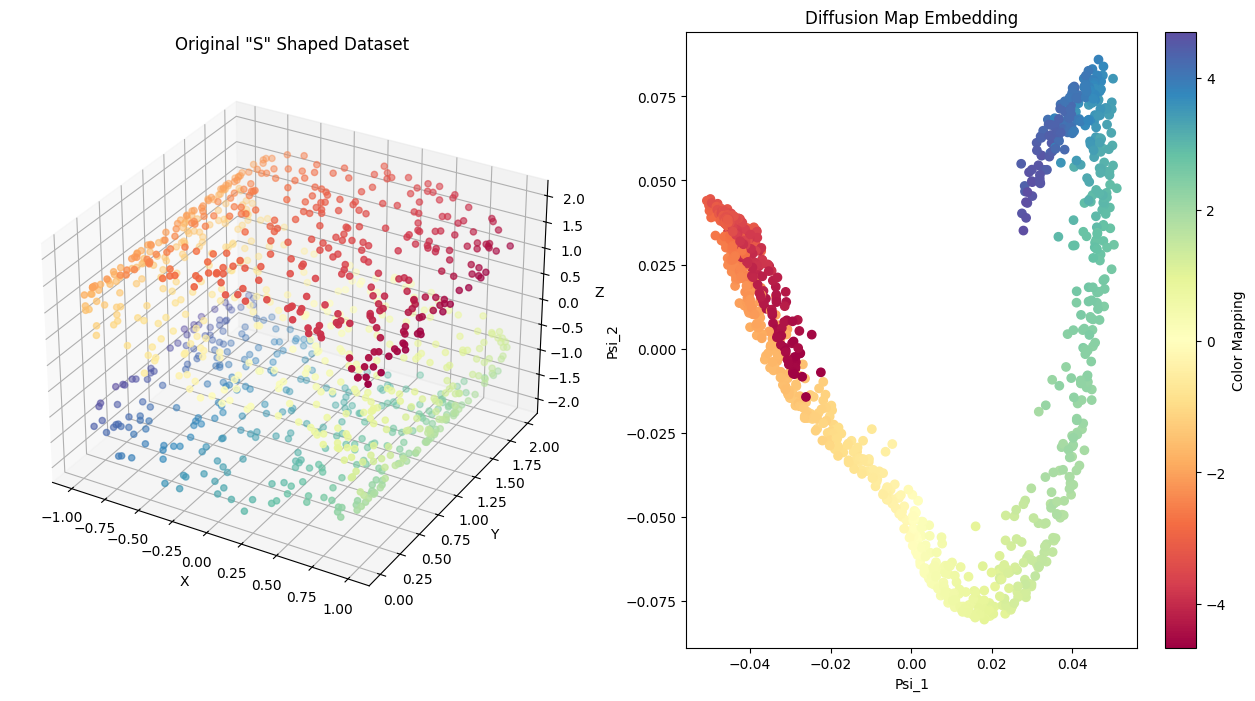

In [27]:
# Generate the "S" shaped dataset
X, color = make_s_curve(1000, random_state=42)
# Compute the pairwise distance matrix
D = pairwise_distances(X)
# Compute the affinity matrix using Gaussian kernel
sigma = 1.0  # Gaussian kernel width
A = np.exp(-D**2 / (2. * sigma**2))
# Row normalization
row_sums = A.sum(axis=1)
P = A / row_sums[:, np.newaxis]
# Eigenvalue decomposition for diffusion map embedding
# Update to use 'subset_by_index' instead of 'eigvals'
eigenvalues, eigenvectors = eigh(P, subset_by_index=[P.shape[0]-3, P.shape[0]-2])
# Normalize the eigenvectors to use as embedding coordinates
psi_1 = eigenvectors[:, 1] / np.sqrt(eigenvalues[1])
psi_2 = eigenvectors[:, 0] / np.sqrt(eigenvalues[0])
# Visualization
fig = plt.figure(figsize=(16, 8))
# Original "S" shaped dataset
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title('Original "S" Shaped Dataset')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# Diffusion map embedding
ax2 = fig.add_subplot(1, 2, 2)
scatter = ax2.scatter(psi_1, psi_2, c=color, cmap=plt.cm.Spectral)
ax2.set_title('Diffusion Map Embedding')
ax2.set_xlabel('Psi_1')
ax2.set_ylabel('Psi_2')
plt.colorbar(scatter, ax=ax2, label='Color Mapping')
plt.show()

## Illustration of the steps involved

### Step 1:  Load Distance Matrix  

In [28]:
# Take one of the prDs for analyis among all the prDs by input_data[i]
# In this case, we select the projection direction 2
n=2
input_data_sample = input_data[n]
prD_file = open(input_data_sample[0], 'rb')
data_from_prD = pickle.load(prD_file)
print(data_from_prD.keys())
distance_matrix = data_from_prD['D']
print("Shape of the Distance Matrix")
print(distance_matrix.shape)
print("Distance Matrix from one of the projection Directions")
print(distance_matrix)

dict_keys(['D', 'ind', 'q', 'CTF', 'imgAll', 'msk2', 'PD', 'imgAvg'])
Shape of the Distance Matrix
(398, 398)
Distance Matrix from one of the projection Directions
[[ 5.72204590e-06  1.82478851e+10  1.81443223e+10 ...  1.79281125e+10
   1.69253843e+10  1.74284084e+10]
 [ 1.82478851e+10 -3.81469727e-06  1.96162913e+10 ...  1.91619064e+10
   1.85194379e+10  1.89229970e+10]
 [ 1.81443223e+10  1.96162913e+10 -2.28881836e-05 ...  1.92300270e+10
   1.86547608e+10  1.85723531e+10]
 ...
 [ 1.79281125e+10  1.91619064e+10  1.92300270e+10 ...  2.67028809e-05
   1.78225499e+10  1.84228864e+10]
 [ 1.69253843e+10  1.85194379e+10  1.86547608e+10 ...  1.78225499e+10
   7.62939453e-06  1.71367296e+10]
 [ 1.74284084e+10  1.89229970e+10  1.85723531e+10 ...  1.84228864e+10
   1.71367296e+10 -1.14440918e-05]]


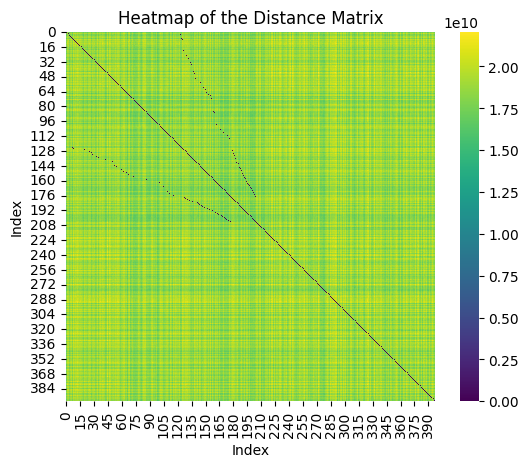

In [29]:
# Display the distance matrix
sns.heatmap(distance_matrix, cmap='viridis', square=True)
plt.title('Heatmap of the Distance Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.show()

### Step 2:  Perform initial spectral embedding

In [30]:
# Step 2A: Find the nearest neighbors for the DMembedding function 
nS = distance_matrix.shape[1]
k = nS
print("Nearest neighbors :", k)

# Step 2B: Assign prefsigma and tune values
prefsigma = 60000
tune = p.tune
print("prefsigma:", prefsigma)
print("tune:", tune)

# Step 2C: Perform Diffusion Map Embedding
lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared = DMembeddingIIop(distance_matrix, k, tune, prefsigma)
print("Initial spectral embedding performed.")
print("The shape of psi is", psi.shape)
print("The shape of lamb is", lamb.shape)

Nearest neighbors : 398
prefsigma: 60000
tune: 3
Initial spectral embedding performed.
The shape of psi is (398, 15)
The shape of lamb is (16,)


### Step 3: Trim the manifold based on the specified radius

In [31]:
rad = p.rad
print("The trimming radius is", rad)
posPath1 = get_psiPath(psi, rad, 0)
print("The length of posPath1 is", len(posPath1))
cc = 0
while len(posPath1) < nS:
    cc += 1
    nS = len(posPath1)
    D1 = D[posPath1][:, posPath1]
    k = D1.shape[0]
    lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared = DMembeddingIIop(D1, k, tune, prefsigma)
print("The trimmed distance matrix is of shape", D1.shape)
print("The shape of psi is", psi.shape)
print("The length of lamb is", len(lamb))

The trimming radius is 5
The length of posPath1 is 386
The trimmed distance matrix is of shape (386, 386)
The shape of psi is (386, 15)
The length of lamb is 16


### Step 4: Update positions based on manifold trimming

In [32]:
posPathInt = get_psiPath(psi, rad, 0)
posPath1 = posPath1[posPathInt]
print(posPath1.shape)

(386,)


### Step 5: Visualize the eigenvalues and the first four dimensions of the embedded coordinate

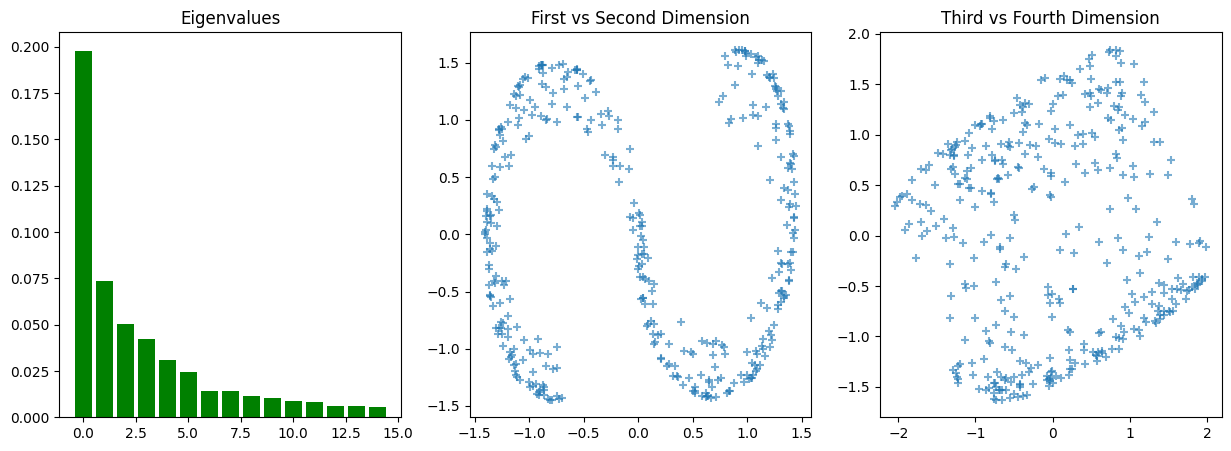

In [33]:
show_plot(lamb, psi, '')

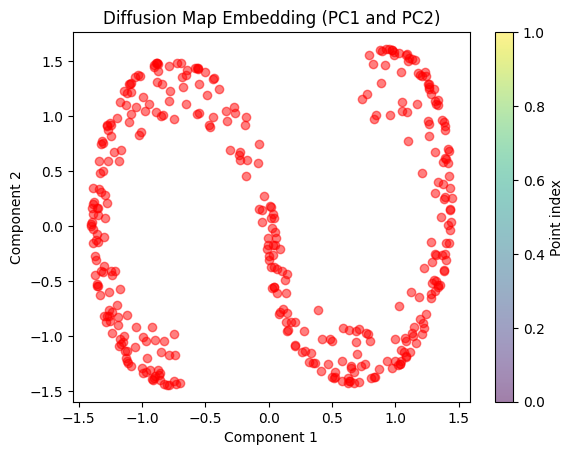

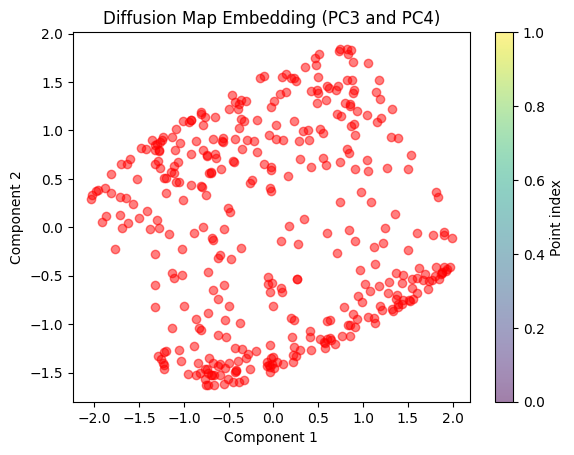

In [34]:
# Plot the first two principal components
plt.scatter(psi[:, 0], psi[:, 1], c='red', alpha=0.5)
plt.title('Diffusion Map Embedding (PC1 and PC2)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Point index')
plt.show()

# Plot the next two principal components
plt.scatter(psi[:, 2], psi[:, 3], c='red', alpha=0.5)
plt.title('Diffusion Map Embedding (PC3 and PC4)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Point index')
plt.show()

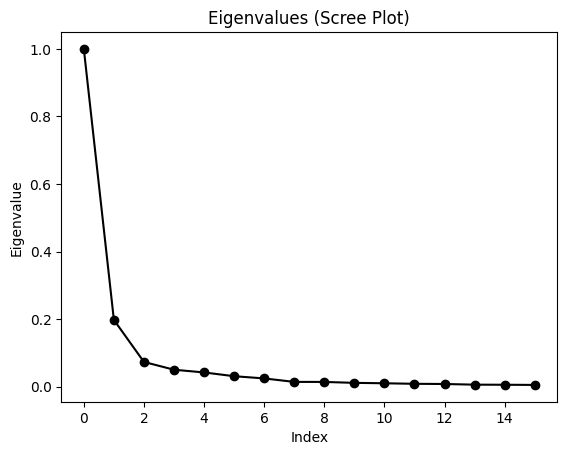

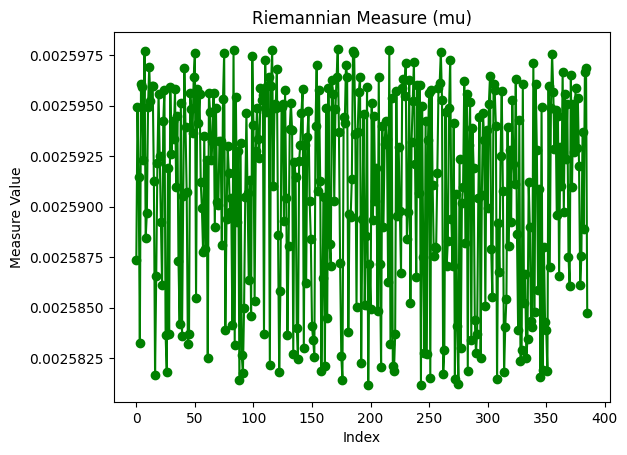

In [35]:
# Plot the eigen values
plt.figure()
plt.plot(lamb, marker='o', color='black')  
plt.title('Eigenvalues (Scree Plot)')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(False) 
plt.show()

# Plotting the  Riemannian Measure
plt.figure()
plt.plot(mu, marker='o', linestyle='-', color='green')
plt.title('Riemannian Measure (mu)')
plt.xlabel('Index')
plt.ylabel('Measure Value')
plt.grid(False)
plt.show()